# ConvNeXt V2

- loss: Binary Cross Entropy
- metrics: ROAUC
- trainable: after model.convnextv2.encoder.stages[3]

## Load Model

In [1]:
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification, get_cosine_schedule_with_warmup
import torch
from datasets import load_dataset

from utils.utils import load_img

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

1.13.1+cu117
True
4
0
Tesla T4
(7, 5)


## 学習データの可視化

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# 食品と飲料をランダムに5個ずつ可視化する
df_train = pd.read_csv('train.csv')
df_train['num'] = df_train['image_name'].str[:-4].astype(int)

d_vis = df_train[df_train['label']==0].sample(5)['num'].tolist()
f_vis = df_train[df_train['label']==1].sample(5)['num'].tolist()

In [4]:
# データの偏り
print(f"N of drinks: {len(df_train[df_train['label']==0])}")
print(f"N of foods: {len(df_train[df_train['label']==1])}")

N of drinks: 994
N of foods: 1182


In [5]:
def show5img(ilist, stitle=None):
    n_cols = 5
    n_rows = (len(ilist)-1)//5+1
    
    fig = plt.figure(figsize=(n_cols*2, n_rows*2))
    for n, i in enumerate(ilist):
        ax = fig.add_subplot(n_rows, n_cols, n+1)
        im = load_img(i)
        im = np.asarray(im)
        ax.imshow(im)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(i)
    if stitle:
        fig.suptitle(stitle)
    fig.tight_layout()
    fig.show()

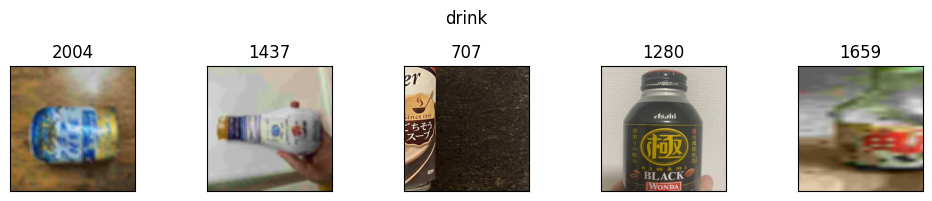

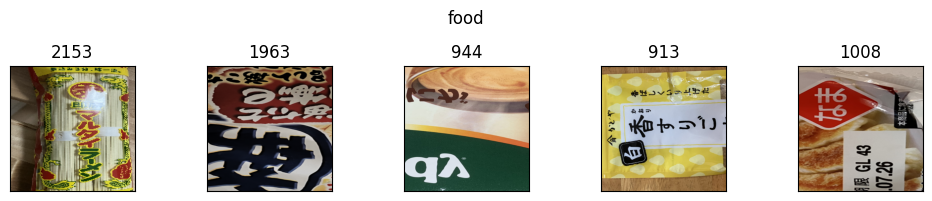

In [6]:
show5img(d_vis, stitle='drink')
show5img(f_vis, stitle='food')

## 転移学習

In [7]:
import torch.nn as nn
from torchvision import transforms

from sklearn.model_selection import StratifiedKFold

In [8]:
device = torch.device('cuda')

データセット作成

In [9]:
# folding
n_folds = 5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
df_train['fold'] = -1
for i, (_, val_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[val_idx, 'fold'] = i

In [10]:
df_train

,image_name,label,num,fold
0,0000.png,0,0,4
1,0001.png,1,1,2
2,0002.png,1,2,3
3,0003.png,1,3,0
4,0004.png,0,4,3
...,...,...,...,...
2171,2171.png,1,2171,3
2172,2172.png,1,2172,2
2173,2173.png,1,2173,3
2174,2174.png,0,2174,2


In [11]:
# テストデータ
df_test = pd.read_csv('sample_submit.csv', header=None)
df_test.columns = ['image_name', 'label']
df_test['num'] = df_test['image_name'].str[:-4].astype(int)
df_test['label'] = -1

In [12]:
df_test

,image_name,label,num
0,2176.png,-1,2176
1,2177.png,-1,2177
2,2178.png,-1,2178
3,2179.png,-1,2179
4,2180.png,-1,2180
...,...,...,...
2175,4351.png,-1,4351
2176,4352.png,-1,4352
2177,4353.png,-1,4353
2178,4354.png,-1,4354


In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomCrop(256),
            transforms.RandomCrop(384),
            transforms.RandomCrop(512),
        ]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)],
            p=0.67,
        ),
        transforms.RandomApply(
            [transforms.GaussianBlur(3, sigma=(0.1, 2.0))],
            p=0.67,
        ),
        transforms.Resize((512, 512)),
        transforms.RandomApply(
            [transforms.RandomRotation(180)],
            p=0.5,
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.33, scale=(0.02, 0.3)),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'tta': transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomCrop(448),
            transforms.RandomCrop(512),
        ]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)],
            p=0.67,
        ),
        transforms.RandomApply(
            [transforms.GaussianBlur(3, sigma=(0.1, 2.0))],
            p=0.67,
        ),
        transforms.Resize((512, 512)),
        # transforms.RandomApply(
        #     [transforms.RandomRotation(180)],
        #     p=0.5,
        # ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        # transforms.RandomErasing(p=0.33, scale=(0.02, 0.1)),
    ]),
}

In [14]:
# 例
def showTimg(n, phase='train'):
    image = load_img(0)
    image_t = data_transforms[phase](image)
    
    img1 = np.asarray(image)
    img2 = image_t.numpy().transpose((2,1,0))
    
    fig = plt.figure(figsize=(2*2, 1*2))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img1)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
    ax1.set_title(f'Raw_{n}')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img2)
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    ax2.set_title(f'Transformed_{n}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


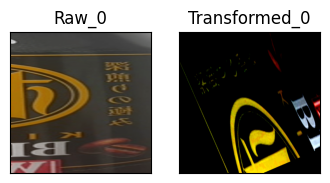

In [15]:
showTimg(0, phase='train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


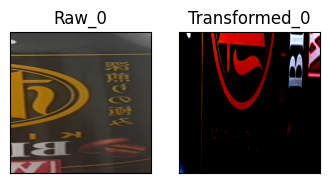

In [16]:
showTimg(0, phase='valid')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


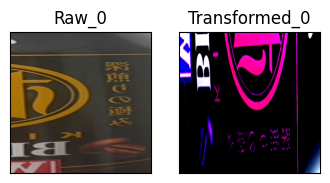

In [17]:
showTimg(0, phase='tta')

In [18]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform, tt='train'):
        if tt == 'train':
            self.dir = 'train/'
        elif tt == 'test':
            self.dir = 'test/'
        
        self.df = df
        self.transform = transform
        self.labels = np.expand_dims(df['label'].values, 1)
        self.labels = self.labels.astype(float)

    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.labels)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        num = self.df['num'].values[idx]
        image = load_img(num)
        image = self.transform(image)
        return image, self.labels[idx]

In [19]:
def foldData(fold, bs=32):
    df_train_ = df_train[df_train['fold']!=fold]
    df_valid_ = df_train[df_train['fold']==fold]
    df_test_ = df_test
    
    image_datasets = {
        'train': MyDataset(df_train_, data_transforms['train'], tt='train'),
        'valid': MyDataset(df_valid_, data_transforms['valid'], tt='train'),
        'vta': MyDataset(df_valid_, data_transforms['tta'], tt='train'),
        'test': MyDataset(df_test_, data_transforms['valid'], tt='test'),
        'tta': MyDataset(df_test_, data_transforms['tta'], tt='test'),
    }
    
    dataloaders = {
        'train': torch.utils.data.DataLoader(image_datasets['train'],
                                             batch_size=bs, shuffle=True, num_workers=16, pin_memory=True),
        'valid': torch.utils.data.DataLoader(image_datasets['valid'],
                                             batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
        'vta': torch.utils.data.DataLoader(image_datasets['vta'],
                                           batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
        'test': torch.utils.data.DataLoader(image_datasets['test'],
                                            batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
        'tta': torch.utils.data.DataLoader(image_datasets['tta'],
                                           batch_size=32, shuffle=False, num_workers=16, pin_memory=True),
    }
    
#     return train_idx, valid_idx, image_datasets, dataloaders
    return image_datasets, dataloaders

モデル構築

In [20]:
from torcheval.metrics import BinaryAUROC
import torch.optim as optim
from torcheval.metrics.functional import binary_auroc

In [21]:
def loadNewModel():
    m = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-huge-22k-512")
    m.classifier = nn.Linear(2816, 1, bias=True)
    m = torch.nn.DataParallel(m, device_ids=[0, 1, 2, 3]) # make parallel
    m.to(device)
    for p in m.parameters():
        p.requires_grad = False
    return m

学習

In [22]:
import copy, time
from numba import cuda

In [23]:
scaler = torch.cuda.amp.GradScaler() 

In [24]:
def train(model, criterion, optimizer, scheduler, image_datasets, dataloaders, epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{epochs-1}')
        print('-' * 10)
        
        for phase in ('train', 'valid'):
            if phase == 'train':
                is_train = True
                model.train()  # Set model to training mode
            else:
                is_train = False
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_auc = 0.0
            
            # イタレーション
            for b, (inputs, labels) in enumerate(dataloaders[phase]):
                print(f'\rBatch: {b}/{len(image_datasets[phase])//dataloaders[phase].batch_size} ({phase})', end="")
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(is_train):
                    with torch.cuda.amp.autocast(): 
                        outputs = model(inputs).logits
                        # loss = criterion(torch.flatten(outputs), torch.flatten(labels))
                        loss = criterion(outputs, labels)
                    auc = binary_auroc(torch.flatten(torch.sigmoid(outputs)),
                                       torch.flatten(labels))

                    # backward + optimize only if in training phase
                    if is_train:
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update() 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_auc +=  auc * inputs.size(0)
                
                del loss, auc, labels, inputs, outputs
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_auc = running_auc / len(image_datasets[phase])
            
            print()
            print(f'{phase} Loss: {epoch_loss:.4f} AUC: {epoch_auc:.4f}')
            
            # deep copy the model
            if phase == 'valid' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
            del epoch_loss, epoch_auc, running_loss, running_auc
            torch.cuda.empty_cache()
            
        scheduler.step()
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val AUC: {best_auc:.4f}')
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    del best_model_wts
    return model

In [25]:
### パラメータ変更可能な部分 ###
"""
  model.module.convnextv2.embeddings

  model.module.convnextv2.encoder.stages[0]
  -> model.module.convnextv2.encoder.stages[0].layers[0] ~ [2]

  model.module.convnextv2.encoder.stages[1]
  -> model.module.convnextv2.encoder.stages[1].layers[0] ~ [2]

  model.module.convnextv2.encoder.stages[2]
  -> model.module.convnextv2.encoder.stages[2].layers[0] ~ [26]

  model.module.convnextv2.encoder.stages[3]
  -> model.module.convnextv2.encoder.stages[3].layers[0] ~ [2]

  model.module.convnextv2.layernorm

  model.module.classifier
"""

'\n  model.module.convnextv2.embeddings\n\n  model.module.convnextv2.encoder.stages[0]\n  -> model.module.convnextv2.encoder.stages[0].layers[0] ~ [2]\n\n  model.module.convnextv2.encoder.stages[1]\n  -> model.module.convnextv2.encoder.stages[1].layers[0] ~ [2]\n\n  model.module.convnextv2.encoder.stages[2]\n  -> model.module.convnextv2.encoder.stages[2].layers[0] ~ [26]\n\n  model.module.convnextv2.encoder.stages[3]\n  -> model.module.convnextv2.encoder.stages[3].layers[0] ~ [2]\n\n  model.module.convnextv2.layernorm\n\n  model.module.classifier\n'

In [26]:
specs = [
    # {
    #     'bs': 32,
    #     'trainLayers': 1,
    #     'lr': 1e-3,
    #     'epochs': 15,
    #     'num_warmup_steps': 5,  # CosSchWarm
    #     'num_training_steps': 20,  # CosSchWarm
    #     'num_cycles': 0.5,  # CosSchWarm
    # },
    # {
    #     'bs': 32,
    #     'trainLayers': 2,
    #     'lr': 1e-3,
    #     'epochs': 15,
    #     'num_warmup_steps': 5,  # CosSchWarm
    #     'num_training_steps': 20,  # CosSchWarm
    #     'num_cycles': 0.5,  # CosSchWarm
    # },
    # {
    #     'bs': 32,
    #     'trainLayers': 3,
    #     'lr': 5e-4,
    #     'epochs': 30,
    #     'num_warmup_steps': 5,  # CosSchWarm
    #     'num_training_steps': 35,  # CosSchWarm
    #     'num_cycles': 1.5,  # CosSchWarm
    # },
    {
        'bs': 24,
        'trainLayers': 6,
        'lr': 1e-4,
        'epochs': 100,
        'num_warmup_steps': 10,  # CosSchWarm
        'num_training_steps': 105,  # CosSchWarm
        'num_cycles': 4.5,  # CosSchWarm
    },
]

In [27]:
def train_spec(i, model_path='model.pth'):
    spec = specs[i]
    
    # datasetsを作る
    image_datasets, dataloaders = foldData(0, bs=spec['bs'])
    
    # 新しいモデルを読み込み
    if i == 0:
        model = loadNewModel()
    else:
        model = torch.load(model_path)
        model.to(device)
        for p in model.parameters():
            p.requires_grad = False
    
    layer_list = [
        model.module.classifier,
        model.module.convnextv2.layernorm,
        model.module.convnextv2.encoder.stages[3],
        model.module.convnextv2.encoder.stages[2].layers[26],
        model.module.convnextv2.encoder.stages[2].layers[25],
        model.module.convnextv2.encoder.stages[2].layers[24],
        model.module.convnextv2.encoder.stages[2].layers[22],
        model.module.convnextv2.encoder.stages[2].layers[21],
    ]
    
    for j in range(spec['trainLayers']):
        layer = layer_list[j]
        for p in layer.parameters():
            p.requires_grad = True
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=None)
    if False:
    # if i < len(specs)-2:
        optimizer = optim.SGD(model.parameters(), lr=spec['lr'], momentum=0.9)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=spec['sch_steps'], gamma=spec['sch_gamma'])
    else:
        optimizer = optim.AdamW(model.parameters(), lr=spec['lr'])
        lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                       num_warmup_steps=spec['num_warmup_steps'],
                                                       num_training_steps=spec['num_training_steps'],
                                                       num_cycles=spec['num_cycles'])
    
    model = train(model, criterion, optimizer, lr_scheduler, image_datasets, dataloaders,
                  epochs=spec['epochs'])
    
    torch.save(model, model_path)
    del model
    torch.cuda.empty_cache()

In [ ]:
for i in range(len(specs)):
    print(f'<< Spec: {i} >>')
    train_spec(i)

In [28]:
print(torch.cuda.memory_allocated())

0


In [29]:
model = torch.load('model.pth')
model.to(device)

DataParallel(
  (module): ConvNextV2ForImageClassification(
    (convnextv2): ConvNextV2Model(
      (embeddings): ConvNextV2Embeddings(
        (patch_embeddings): Conv2d(3, 352, kernel_size=(4, 4), stride=(4, 4))
        (layernorm): ConvNextV2LayerNorm()
      )
      (encoder): ConvNextV2Encoder(
        (stages): ModuleList(
          (0): ConvNextV2Stage(
            (downsampling_layer): Identity()
            (layers): Sequential(
              (0): ConvNextV2Layer(
                (dwconv): Conv2d(352, 352, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=352)
                (layernorm): ConvNextV2LayerNorm()
                (pwconv1): Linear(in_features=352, out_features=1408, bias=True)
                (act): GELUActivation()
                (grn): ConvNextV2GRN()
                (pwconv2): Linear(in_features=1408, out_features=352, bias=True)
                (drop_path): Identity()
              )
              (1): ConvNextV2Layer(
                (dwconv): Conv2

## 検証

- 通常の代入とTTAで比較

In [36]:
image_datasets, dataloaders = foldData(0, bs=64)

In [37]:
def valid(model, dataloader):
    noutputs = []
    nlabels = []
    for b, (imgs, labels) in enumerate(dataloader):
        print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
        inputs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            noutputs.append(model(inputs).logits)
            nlabels.append(labels)
    alloutputs = torch.cat(noutputs)
    alllabels = torch.cat(nlabels)
    
    preds = torch.sigmoid(torch.flatten(alloutputs))
    auc = binary_auroc(preds, torch.flatten(alllabels))
    print()
    print()
    print(f'AUC: {auc:.4f}')
    
    return preds.cpu().detach().numpy()

In [38]:
def tta(model, dataloader, n=5):
    alloutputs = []
    
    for i in range(n):
        print(f'n: {i}/{n-1}')
        print('-' * 10)
        noutputs = []
        nlabels = []
        for b, (imgs, labels) in enumerate(dataloader):
            print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
            inputs = imgs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                noutputs.append(model(inputs).logits)
                nlabels.append(labels)
        alloutputs.append(torch.cat(noutputs))
        alllabels = torch.cat(nlabels)
        print()
    alloutputs = torch.cat(alloutputs, 1)
    preds = torch.sigmoid(torch.mean(alloutputs, dim=1))
    auc = binary_auroc(preds, torch.flatten(alllabels))
    print()
    print(f'AUC: {auc:.4f}')
    
    return preds.cpu().detach().numpy()

In [41]:
def valMix(model, dataloaders, n=5, mode='valid'):
    # 通常valid
    print(f"=== Normal {'Valid' if mode=='valid' else 'Test'} ===")
    if mode =='valid':
        dataloader = dataloaders['valid']
    elif mode == 'test':
        dataloader = dataloaders['test']
    noutputs = []
    nlabels = []
    for b, (imgs, labels) in enumerate(dataloader):
        print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
        inputs = imgs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            noutputs.append(model(inputs).logits)
            nlabels.append(labels)
    alloutputs = torch.cat(noutputs)
    alllabels = torch.cat(nlabels)
    
    preds1 = torch.sigmoid(torch.flatten(alloutputs))
    auc = binary_auroc(preds1, torch.flatten(alllabels))
    print()
    print()
    print(f'Norml Valid AUC: {auc:.4f}')
    print()
    
    # TTA valid
    print(f"=== {'Valid' if mode=='valid' else 'Test'} Time Augmentation ===")
    if mode =='valid':
        dataloader = dataloaders['vta']
    elif mode == 'test':
        dataloader = dataloaders['tta']
    alloutputs = [alloutputs]
    
    for i in range(n):
        print(f'n: {i}/{n-1}')
        print('-' * 10)
        noutputs = []
        for b, (imgs, labels) in enumerate(dataloader):
            print(f'\rBatch: {b}/{len(dataloader.dataset)//dataloader.batch_size}', end="")
            inputs = imgs.to(device)
            with torch.no_grad():
                noutputs.append(model(inputs).logits)
        alloutputs.append(torch.cat(noutputs))
        print()
    alloutputs = torch.cat(alloutputs, 1)
    preds2 = torch.sigmoid(torch.mean(alloutputs, dim=1))
    auc = binary_auroc(preds2, torch.flatten(alllabels))
    print()
    print(f'VTA AUC: {auc:.4f}')
    print()
    
    # Mix
    print('=== Mixed Valid ===')
    preds1to0 = preds1 - 0
    preds1to1 = 1 - preds1
    preds2to0 = preds2 - 0
    preds2to1 = 1 - preds2
    
    stack = torch.stack([preds1to0, preds1to1, preds2to0, preds2to1])
    pstack = torch.stack([preds1, preds1, preds2, preds2])
    
    argmin = torch.argmin(stack, dim=0)
    preds = torch.diag(pstack[argmin])
    auc = binary_auroc(preds, torch.flatten(alllabels))
    print()
    print(f'Mixed AUC: {auc:.4f}')
    return preds1.cpu().detach().numpy(), preds2.cpu().detach().numpy(), preds.cpu().detach().numpy()

In [42]:
val, vta, mix = valMix(model, dataloaders, n=5)

=== Normal Valid ===
Batch: 13/13

Norml Valid AUC: 0.9877

=== Valid Time Augmentation ===
n: 0/4
----------
Batch: 13/13
n: 1/4
----------
Batch: 13/13
n: 2/4
----------
Batch: 13/13
n: 3/4
----------
Batch: 13/13
n: 4/4
----------
Batch: 13/13

VTA AUC: 0.9819

=== Mixed Valid ===

Mixed AUC: 0.9880


In [43]:
# 例
def showRes(n, df, preds, preds2=None, preds3=None, start=0):
    n_cols = 5
    n_rows = (n-1)//5+1
    
    fig = plt.figure(figsize=(n_cols*2, n_rows*2))
    
    for i in range(n):
        loc = i + start
        num = df['num'].iloc[loc]
        lab = df['label'].iloc[loc]
        im = image = load_img(num)
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        im = np.asarray(im)
        ax.imshow(im)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        title = f'Label: {lab}\nPred: {preds[loc]:.2f}'
        if preds2 is not None:
            title += f'\nPred2: {preds2[loc]:.2f}'
        if preds3 is not None:
            title += f'\nPred3: {preds3[loc]:.2f}'
        
        ax.set_title(title)
        
    fig.suptitle('Prediction')
    fig.tight_layout()
    fig.show()

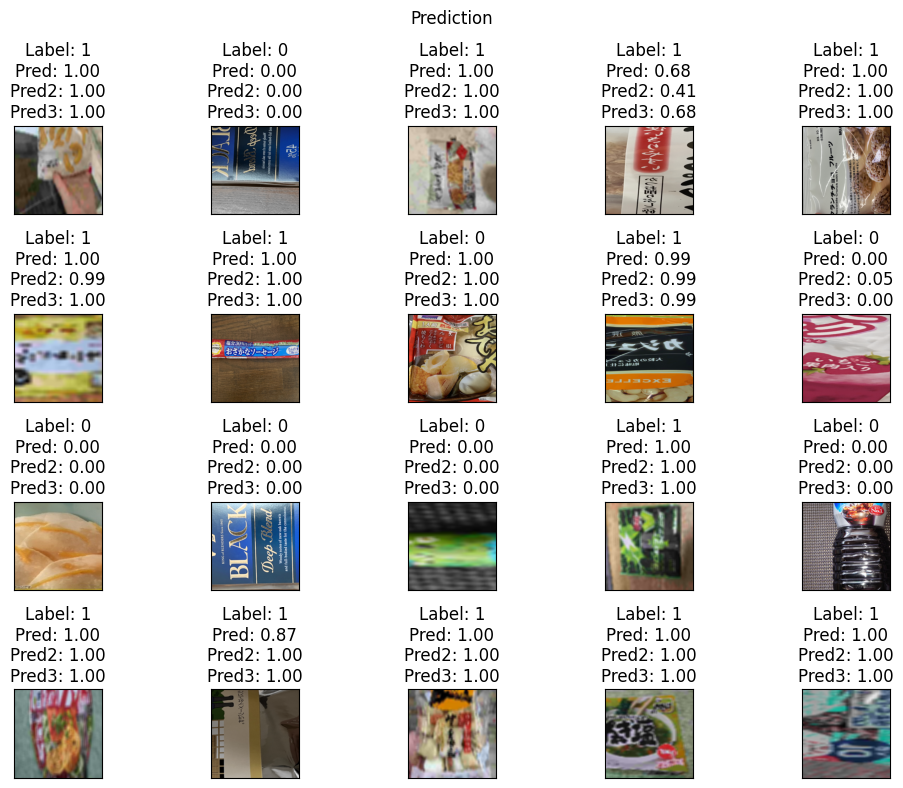

In [44]:
showRes(20, df_train[df_train['fold']==0], val, vta, mix, start=20)

## 推論・提出

In [45]:
test, tta, tmix = valMix(model, dataloaders, n=5, mode='test')

=== Normal Test ===


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch: 68/68

Norml Valid AUC: 0.5000

=== Test Time Augmentation ===
n: 0/4
----------
Batch: 68/68
n: 1/4
----------
Batch: 68/68
n: 2/4
----------
Batch: 68/68
n: 3/4
----------
Batch: 68/68
n: 4/4
----------
Batch: 68/68

VTA AUC: 0.5000

=== Mixed Valid ===

Mixed AUC: 0.5000


予測値の確認

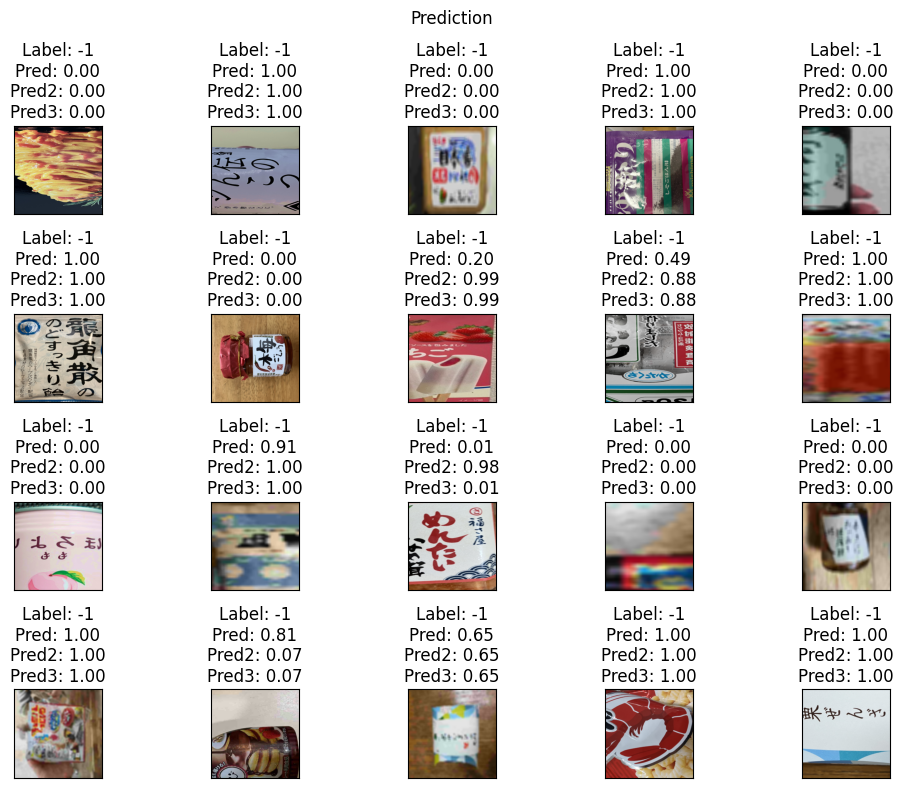

In [46]:
showRes(20, df_test, test, tta, tmix, start=0)

In [49]:
df_submit = df_test[['image_name', 'label']]
df_submit['label'] = tmix
df_submit.to_csv('submit.csv', header=None, index=None)

/var/tmp/ipykernel_1513391/3219145343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submit['label'] = tmix


提出

In [50]:
%%bash
signate submit --competition-id=1106 submit.csv --note model1-2_noCV_tmix

You have successfully submitted your predictions.We will send you the submission result to your email address.
